# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1CkSngXc78HwSeuaFpuGcCwKXcYAJW1Ax/view?usp=sharing

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

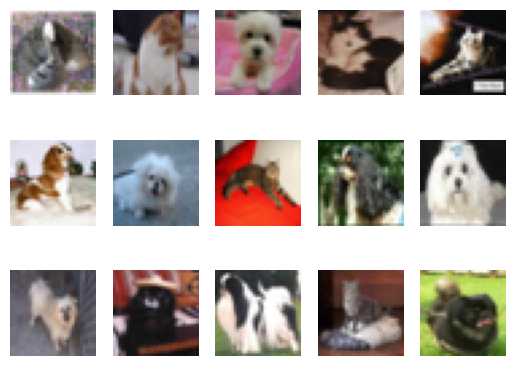

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [5]:
# General formula (in this example we know batch_size = 1)
print("Training data size: ", len(train_loader) * train_loader.batch_size)
print("Training data size: ", len(val_loader) * val_loader.batch_size)
print("Training data size: ", len(test_loader) * test_loader.batch_size)

Training data size:  8000
Training data size:  2000
Training data size:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

If we only use Training + Test data, the model will optimize towards (overfit to) test data.

Therefore, if we use the validation set with training set for training, we are guaranteed that our results from test data can be trusted

(results that resembles the user using our model for prediction)

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
small_count = 0
for param in small_net.parameters():
    small_count += param.numel()

large_count = 0
for param in large_net.parameters():
    large_count += param.numel()

print(small_count)
print(large_count)

386
9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [10]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

batch_size = 64, learning_rate = 0.01, num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

model_small_bs64_lr0.01_epoch0  
model_small_bs64_lr0.01_epoch1  
model_small_bs64_lr0.01_epoch2  
model_small_bs64_lr0.01_epoch3  
model_small_bs64_lr0.01_epoch4  

Each file contains current model's state: net.state_dict() after each epoch.
The state_dict() is a Python dictionary that maps each layer to its parameter tensor, containing all the modified weights and biases

model_small_bs64_lr0.01_train_err.csv  
model_small_bs64_lr0.01_train_loss.csv    

CSV files containing Training error and loss for all 5 epochs during training  

model_small_bs64_lr0.01_val_err.csv  
model_small_bs64_lr0.01_val_loss.csv   

CSV files containing Validation error and loss for all 5 epochs during training  

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [11]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [12]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.676514790058136 |Validation err: 0.37, Validation loss: 0.654131855815649
Epoch 2: Train err: 0.36325, Train loss: 0.6481061215400696 |Validation err: 0.3895, Validation loss: 0.6607548110187054
Epoch 3: Train err: 0.3525, Train loss: 0.6373614816665649 |Validation err: 0.3465, Validation loss: 0.6261459644883871
Epoch 4: Train err: 0.34125, Train loss: 0.6226562075614929 |Validation err: 0.3335, Validation loss: 0.6181808523833752
Epoch 5: Train err: 0.3335, Train loss: 0.6127196784019471 |Validation err: 0.327, Validation loss: 0.6125406548380852
Epoch 6: Train err: 0.3245, Train loss: 0.6012994024753571 |Validation err: 0.323, Validation loss: 0.605414055287838
Epoch 7: Train err: 0.32425, Train loss: 0.5946023759841919 |Validation err: 0.32, Validation loss: 0.5971760079264641
Epoch 8: Train err: 0.31625, Train loss: 0.5870555379390716 |Validation err: 0.316, Valid

In [13]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4785, Train loss: 0.6912403373718262 |Validation err: 0.4475, Validation loss: 0.6879571303725243
Epoch 2: Train err: 0.442625, Train loss: 0.684390170097351 |Validation err: 0.426, Validation loss: 0.6833558473736048
Epoch 3: Train err: 0.409625, Train loss: 0.6717938461303711 |Validation err: 0.3885, Validation loss: 0.659625057131052
Epoch 4: Train err: 0.371375, Train loss: 0.6478279495239258 |Validation err: 0.3695, Validation loss: 0.6479862276464701
Epoch 5: Train err: 0.35125, Train loss: 0.6294472141265869 |Validation err: 0.347, Validation loss: 0.6339765731245279
Epoch 6: Train err: 0.33425, Train loss: 0.6129775280952454 |Validation err: 0.3395, Validation loss: 0.6241807490587234
Epoch 7: Train err: 0.32925, Train loss: 0.6046936700344085 |Validation err: 0.3225, Validation loss: 0.6052001565694809
Epoch 8: Train err: 0.313125, Train loss: 0.5851069984436035 |Validation err: 0

**Obviously large_net longer to train, since there are more layers to calculate, more parameters to be updated**
- Small: Total time elapsed: 92.32 seconds
- Large: Total time elapsed: 97.39 seconds

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

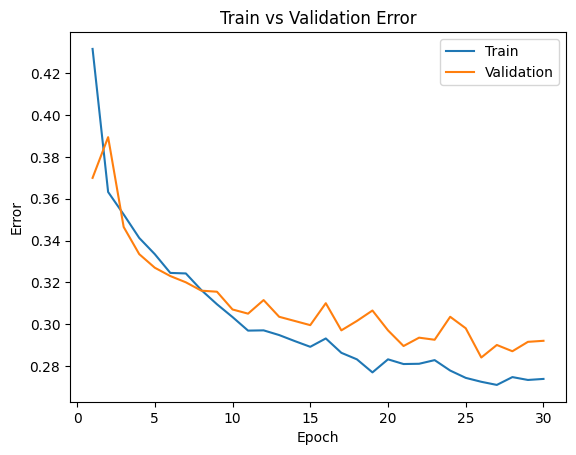

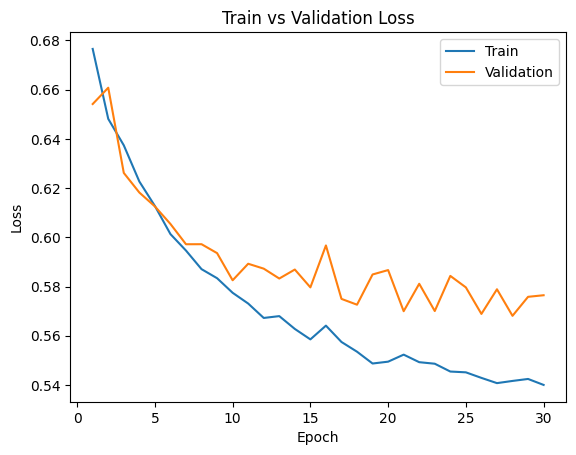

In [14]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

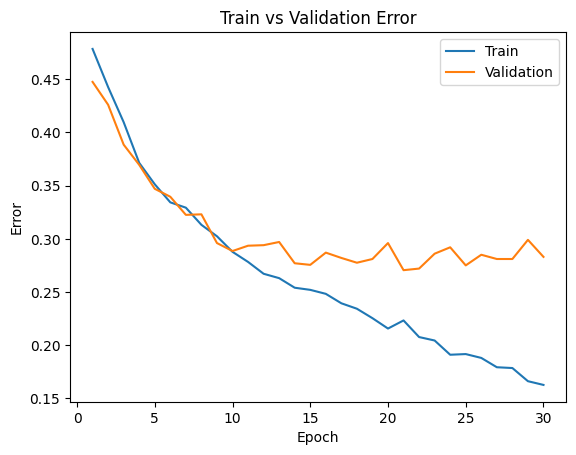

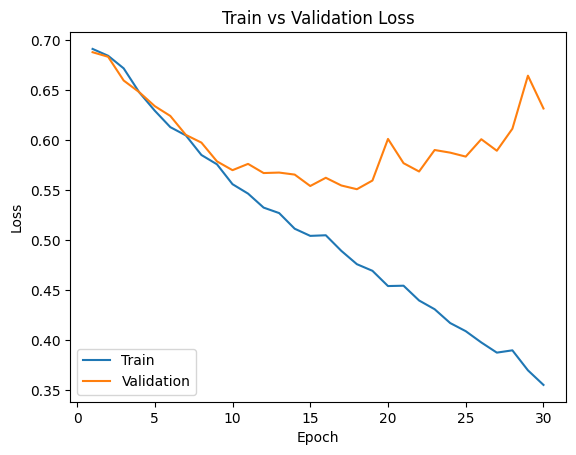

In [15]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Similar**: At the first epochs, Training error and Training loss is high. These decrease during the training process (which shows that the model is indeed learning)

Both small_net and large_net have relatively same fluctuations in error and loss (since they both have the same ammount of batch size = 64)

Validation error and loss decreases until epoch 5-10, then it slows down, starts diverging from Training error/loss (for small_net) or even increase (for large_net Validation loss). This is the sign of **overfitting**

**Differences**: The Training error & loss for small_net decreases almost exponentially, while that for large_net decreases almost linearly. The large_net achieves much lower Training error & Training loss in the end.

The large_net overfits more (have higher final validation error/loss) compared to small_net. Both models have ~equal lowest Validation error (around 0.28) and Validataion loss (around 0.55)

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360028266907 |Validation err: 0.467, Validation loss: 0.6924686599522829
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493307799101
Epoch 3: Train err: 0.43575, Train loss: 0.6916067419052124 |Validation err: 0.4285, Validation loss: 0.6908544395118952
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.6896596923470497
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.6886942777782679
Epoch 6: Train err: 0.435875, Train loss: 0.6887419753074646 |Validation err: 0.4195, Validation loss: 0.6867837514728308
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267921447754 |Validation er

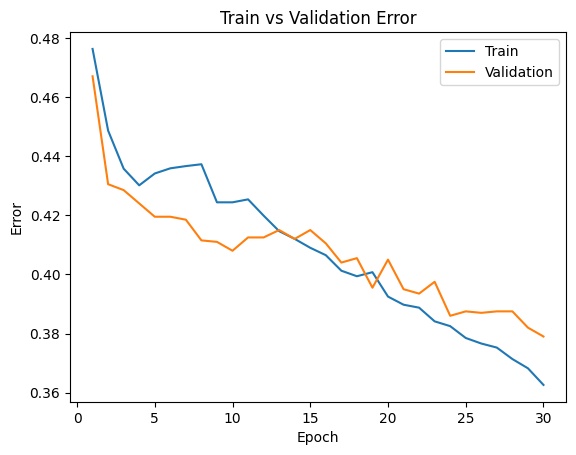

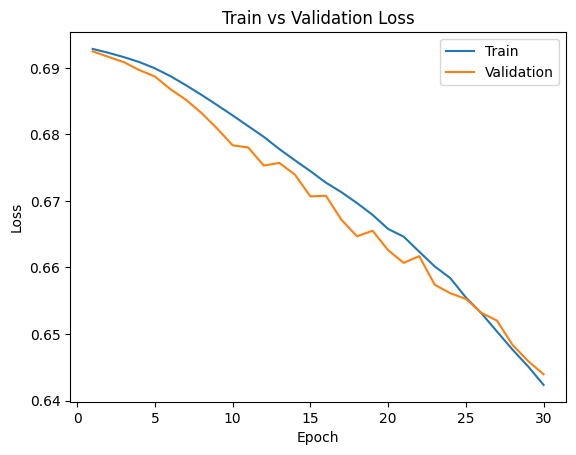

In [16]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate=0.001)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Total time elapsed: 98.45 seconds (slightly longer time than learning_rate = 0.01: 97.39 seconds)

We can observe that the Validation error/loss closely follows the Training error/loss.

However, after 30 epoch, the final Training/Validation error only reaches ~0.38 and Training/Validation loss only reaches ~0.64.

Therefore, 30 epochs in this training corresponds to the first 5-10 epochs when the learning rate was 0.01.

This is because decreasing the learning rate makes the model learn and progress slower towards minimum error/loss.

Therefore, the model will take longer time to reach the optimal error/loss, but approximately same time to train (since same batch size = 64, same number of calculations need to be done, etc.)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808498382569 |Validation err: 0.3565, Validation loss: 0.6350402869284153
Epoch 2: Train err: 0.364375, Train loss: 0.6394594783782959 |Validation err: 0.364, Validation loss: 0.6380155384540558
Epoch 3: Train err: 0.357125, Train loss: 0.6292509632110596 |Validation err: 0.357, Validation loss: 0.6313505992293358
Epoch 4: Train err: 0.351375, Train loss: 0.6222558770179748 |Validation err: 0.3615, Validation loss: 0.6581139843910933
Epoch 5: Train err: 0.3425, Train loss: 0.6109966540336609 |Validation err: 0.327, Validation loss: 0.593532383441925
Epoch 6: Train err: 0.31975, Train loss: 0.5888414912223816 |Validation err: 0.3045, Validation loss: 0.6088876193389297
Epoch 7: Train err: 0.31825, Train loss: 0.5887727000713349 |Validation err: 0.3255, Validation loss: 0.6114899981766939
Epoch 8: Train err: 0.310125, Train loss: 0.5762689855098725 |Validation err: 0.

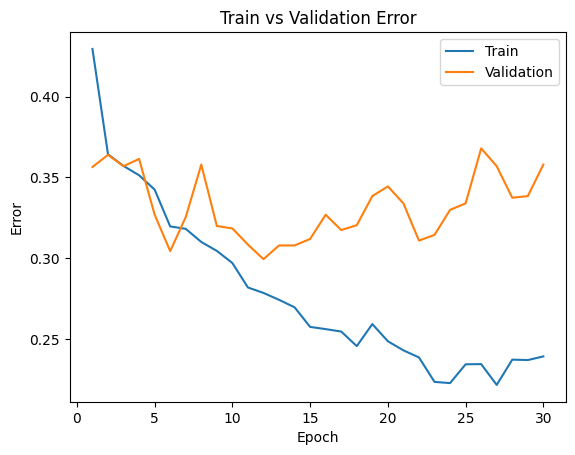

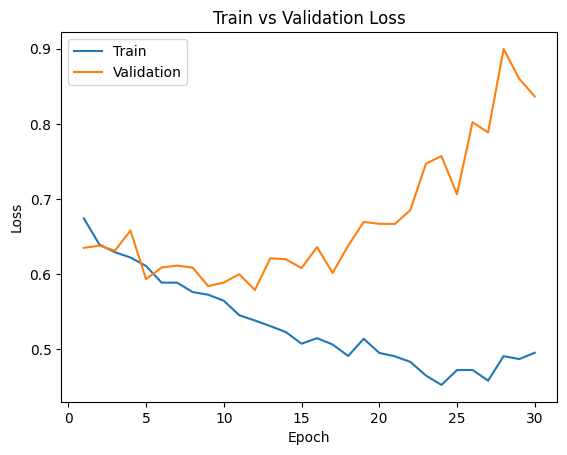

In [17]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

Total time elapsed: 103.31 seconds (slightly longer time than learning rate = 0.01)

We can observe that the Validation error/loss diverges quickly from the Training error/loss. (overfit more easily)

Also, after about 5 epochs, both error and loss increases significantly. The minimum error/loss occurred around epoch 5.

Therefore, comparing the graphs, the first ~15 epochs in this training corresponds to the entire 30 epochs when the learning rate was 0.01.

This is because increasing the learning rate makes the model learn and progress faster towards minimum error/loss, and then away from it.

Therefore, the model will take shorter time to reach the optimal error/loss (quickly overfits), but approximately same time to train (since same batch size = 64, same number of calculations need to be done, etc.)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870153188705
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883531995117664 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.411, Va

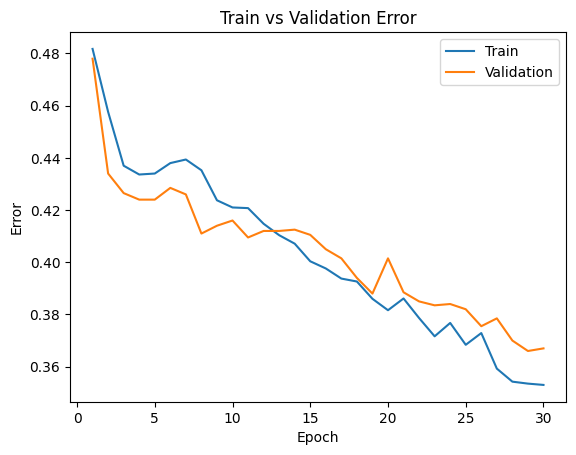

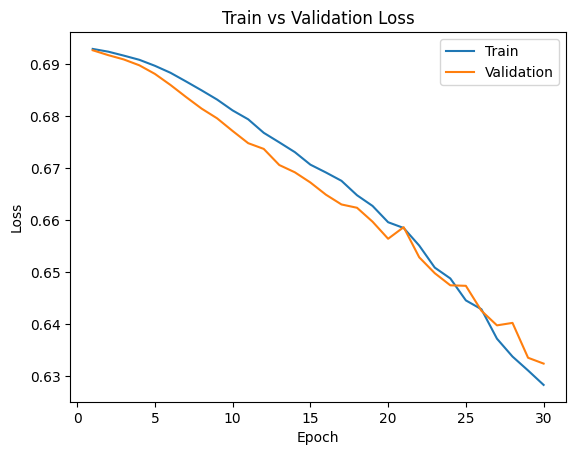

In [18]:
large_net = LargeNet()
train_net(large_net, batch_size=512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Total time elapsed: 87.37 seconds (shorter time than batch_size = 64). This model requires less time to train because smaller batch size means less iterations and calculations needed to finish each epoch.

The results by increasing the batch_size: the Validation error/loss closely follow that of Training. With higher batch size, the model proceeds less stochastic and steps more slowly towards the minimum error/loss (actually in this case, it have not even reached the minimum error/loss of batch_size = 64)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506158471107 |Validation err: 0.378, Validation loss: 0.6512571625709533
Epoch 2: Train err: 0.3655, Train loss: 0.6395608481168747 |Validation err: 0.353, Validation loss: 0.6191524927616119
Epoch 3: Train err: 0.339875, Train loss: 0.6127814228534698 |Validation err: 0.3495, Validation loss: 0.6442944076061249
Epoch 4: Train err: 0.31475, Train loss: 0.5870258185863495 |Validation err: 0.3385, Validation loss: 0.5978640830516815
Epoch 5: Train err: 0.303, Train loss: 0.5651368154883385 |Validation err: 0.305, Validation loss: 0.5715659594535828
Epoch 6: Train err: 0.29025, Train loss: 0.5493593747615815 |Validation err: 0.302, Validation loss: 0.5801575357913971
Epoch 7: Train err: 0.26925, Train loss: 0.5272505192756652 |Validation err: 0.3005, Validation loss: 0.5818900580406189
Epoch 8: Train err: 0.254375, Train loss: 0.5104012369215488 |Validation err: 0.31

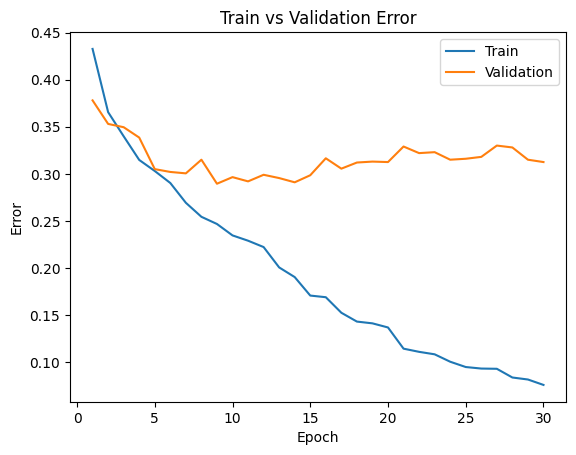

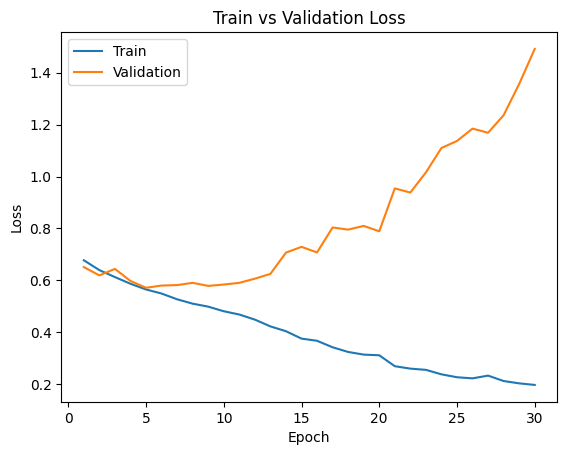

In [19]:
large_net = LargeNet()
train_net(large_net, batch_size=16)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Total time elapsed: 159.68 seconds. Training time is much longer, compared to batch_size = 64, since more iterations and calculations are needed to finish each epoch

Also, the model proceeds with much faster steps, because smaller batch size leads to more stochastivity, leading to the Validation error/loss easily diverges from that of Training (overfits very quickly), as we can also observe from the graphs

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

We observed that decreasing learning rate from 0.01 to 0.001 and increasing batch_size from 64 to 512 results in Validation error/loss that closely follows that of Training (meaning the model improves overtime without overfitting to quickly)

Also, increasing batch size also reduces time required to train the model.

==> I choose (large_net, learning_rate = 0.01, batch_size = 512)

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280534386635 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896311342716 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203593611717 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, V

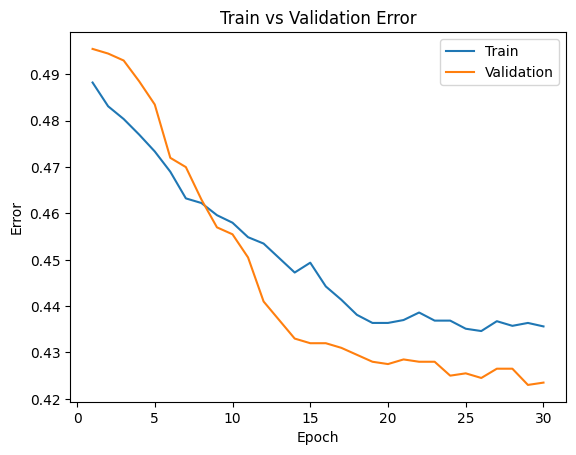

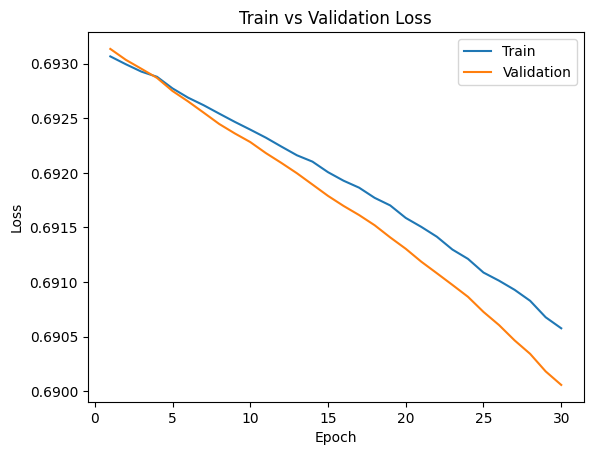

In [20]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.001, batch_size=512)
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

I have also argued in Part 3 graphs that learning_rate = 0.001 and batch_size = 512 progresses more slowly towards to minimum error/loss, which results in a model that can possibly have not reached the most optimal error/loss. Therefore, we can also increase the number of epochs: epoch = 70 to ensure that we have not missed the optimal error/loss.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677443742752 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280534386635 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808465600014 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896311342716 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.6926203593611717 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435587763786 |Validation err: 0.463, V

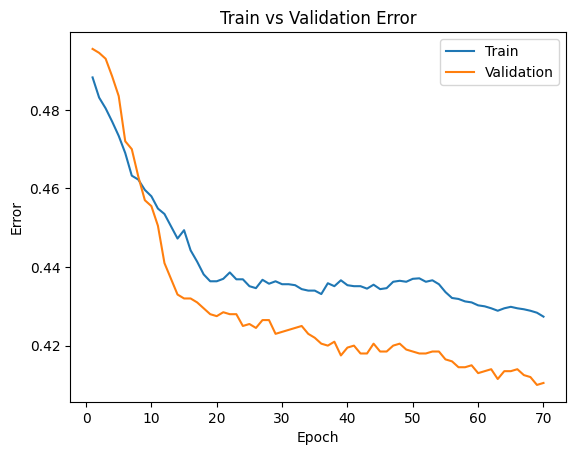

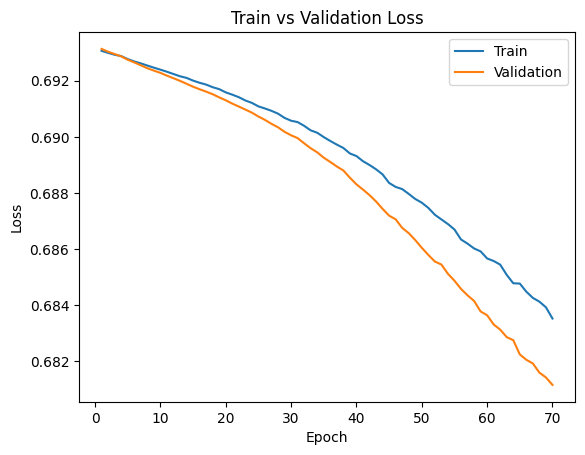

In [21]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.001, batch_size=512, num_epochs=70)
model_path = get_model_name("large", batch_size=512, learning_rate=0.001, epoch=69)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [27]:
net = large_net
model_path = get_model_name(net.name, batch_size=512, learning_rate=0.001, epoch=69)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

Based on all of the above arguments, I chose:
- large_net: Less fluctuations (more stable) compared to small_net. Even though it can overfits to higher error/loss, simply limitting learning_rate and adding overfit prevention methods will solve the issue
- batch_size = 512: less stochastic, progresses more slowly, preventing stepping too big steps and miss the potential minimum error/loss. Less likely to overfit.
- Learning_rate = 0.001: same reason as increased batch_size.
- epoch = 69: same argument as in Part3 c, and also by observation (both Validation and Training error and loss are decreasing linearly at that checkpoint). This is also close to the last checkpoint of the training process for this model.

Even though there are some checkpoints that give lower validation error/loss pair, this checkpoint is the most generalized (not overfitting), so it will be better to be used for testing

Accordingly, the Training and Validation error/loss from the best model checkpoint is:
- **Training error: 0.427375**
- **Training loss: 0.6835209615528584**
- **Validation error: 0.4105**
- **Validation loss: 0.6811540722846985**

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [28]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
test_error, test_loss = evaluate(net, test_loader, criterion)
print("Test error: ", test_error, " and Test loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
Test error:  0.413  and Test loss:  0.6791730970144272


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

Apparently, the test error (0.413) is **slightly higher than** validation error (0.4105). The difference is not significant because in part b, we intentionally chose a more generalized model checkpoint as the **best** model.

However, in general, I would expect the test error to be higher than the validation error because the model checkpoint chosen was based on the model's performance on validation dataset. The model has never seen (not trained on, and not chosen according to) the test data, so the model is more likely to behave worse to any randomness in the test data.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Because how the model behaves to unseen data like test data is also how the model behaves to user data when it's applied in the real world. Therefore, using this method will better evaluate the model performance.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466, Train loss: 0.6897092722356319 |Validation err: 0.461, Validation loss: 0.6892299652099609
Epoch 2: Train err: 0.434875, Train loss: 0.6848809234797955 |Validation err: 0.4415, Validation loss: 0.684259295463562
Epoch 3: Train err: 0.415, Train loss: 0.680446021258831 |Validation err: 0.427, Validation loss: 0.680788055062294
Epoch 4: Train err: 0.41, Train loss: 0.6763757988810539 |Validation err: 0.421, Validation loss: 0.6776017099618912
Epoch 5: Train err: 0.404625, Train loss: 0.6728910319507122 |Validation err: 0.4215, Validation loss: 0.6748959869146347
Epoch 6: Train err: 0.40175, Train loss: 0.6702827922999859 |Validation err: 0.416, Validation loss: 0.6723148375749588
Epoch 7: Train err: 0.39775, Train loss: 0.6676570661365986 |Validation err: 0.417, Validation loss: 0.6703968644142151
Epoch 8: Train err: 0.395875, Train loss: 0.6654616594314575 |Validation err: 0.4175, Vali

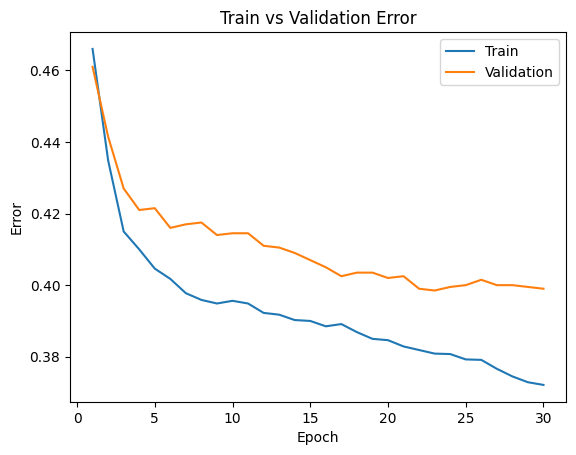

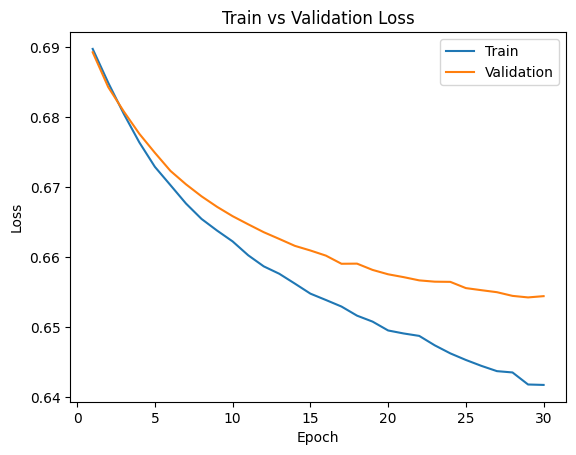

In [29]:
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

ann = ANN()
train_net(ann, batch_size=512, learning_rate=0.001, num_epochs=30)
path = get_model_name("ANN", batch_size=512, learning_rate=0.001, epoch=29)
plot_training_curve(path)

In [31]:
net = ann
path = get_model_name("ANN", batch_size=512, learning_rate=0.001, epoch=3)  # Chose 3 because later epochs all overfit
state = torch.load(path)
net.load_state_dict(state)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)
criterion = nn.BCEWithLogitsLoss()
test_error, test_loss = evaluate(net, test_loader, criterion)
print("ANN: Test error: ", test_error, " and Test loss: ", test_loss)

Files already downloaded and verified
Files already downloaded and verified
ANN: Test error:  0.4075  and Test loss:  0.6746410578489304


Even though the ANN test error (0.4075) is smaller than that of the CNN (0.413) given the same batch_size and learning_rate, this ANN checkpoint has to be chosen at epoch = 3 as later epochs overfits quickly. Therefore, the ANN behaves worse than CNN